# Objective : Optic Disc Segmentation

In [1]:
import numpy as np
import ConfigParser
from matplotlib import pyplot as plt
#Keras
from keras.models import model_from_json
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Convolution2D, MaxPooling2D, ZeroPadding2D, Input, Embedding, LSTM, merge, Lambda, UpSampling2D, Deconvolution2D, Cropping2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.vis_utils import plot_model as plot
from keras.optimizers import SGD

#scikit learn
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import sys
sys.path.insert(0, './lib/')
# help_functions.py
from help_functions import *
# extract_patches.py
from extract_patches import *
from extract_patches import recompone
from extract_patches import recompone_overlap
from extract_patches import paint_border
from extract_patches import kill_border
from extract_patches import pred_only_FOV
from extract_patches import get_data_testing
from extract_patches import get_data_testing_overlap
# pre_processing.py
from help_functions import *
from pre_processing import *
from extract_patches import *
from mask_retina import *
from model import *
from dual_IDG import *

Using TensorFlow backend.


In [2]:
# Load data
create_new_train_test = True
trim = True

if create_new_train_test == True:
    raw_img = load_hdf5("DISC/total_raw.hdf5")
    mask_img = load_hdf5("DISC/total_mask.hdf5")
    raw_train, raw_test, mask_train, mask_test = train_test_split(raw_img, mask_img, test_size = 0.2, random_state = 123)
    write_hdf5(raw_train, "DISC/raw_train.hdf5")
    write_hdf5(raw_test, "DISC/raw_test.hdf5")
    write_hdf5(mask_train, "DISC/mask_train.hdf5")
    write_hdf5(mask_test, "DISC/mask_test.hdf5")
else:
    raw_train = load_hdf5("DISC/raw_train.hdf5")
    raw_test =  load_hdf5("DISC/raw_test.hdf5")
    mask_train = load_hdf5("DISC/mask_train.hdf5")
    mask_test = load_hdf5("DISC/mask_test.hdf5")


# Raw Data Image

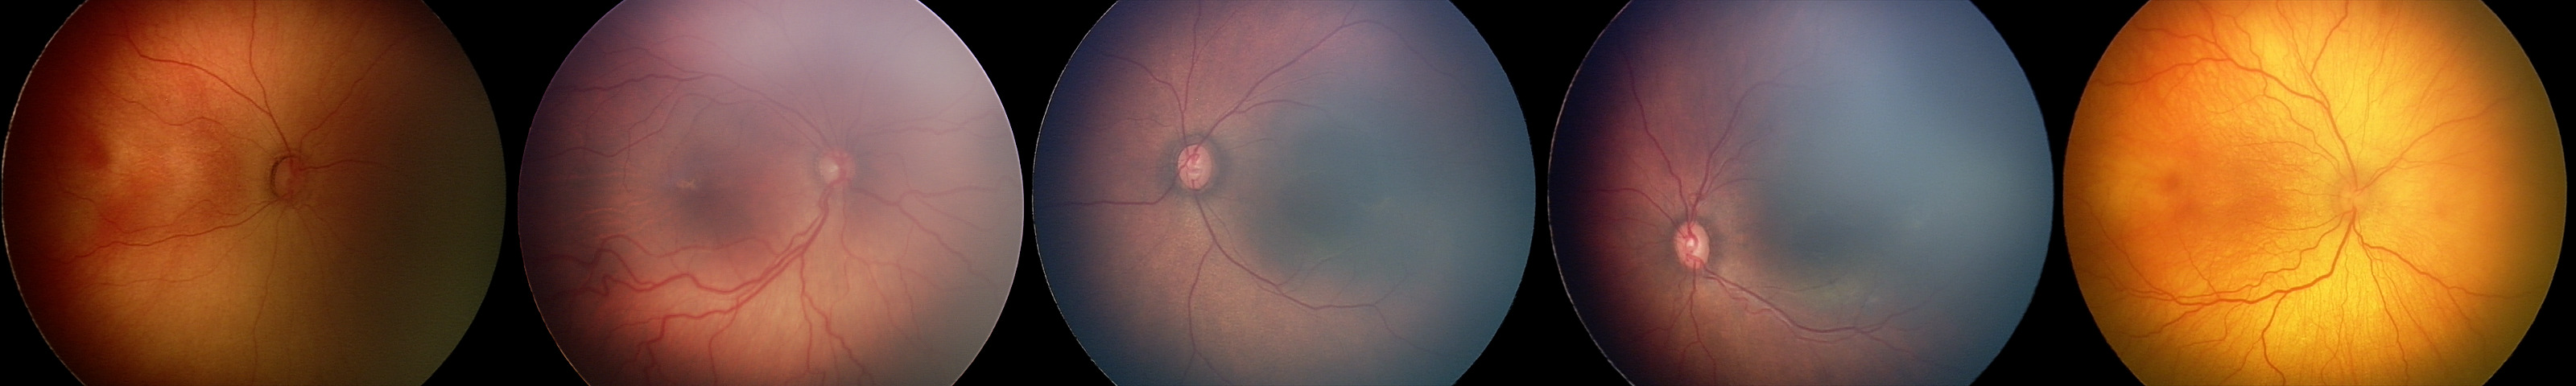

In [3]:
visualize(group_images(raw_train[0:5,:,:,:],5),'raw_img')

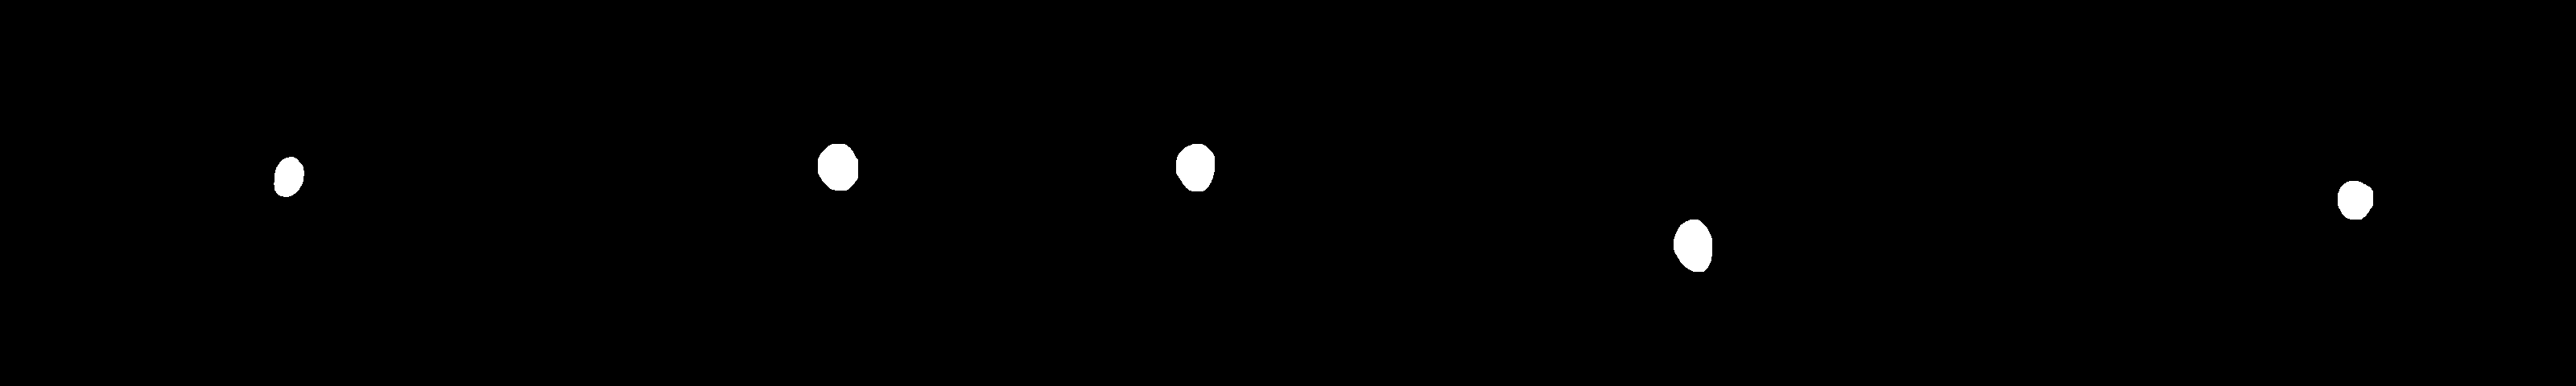

In [4]:
visualize(group_images(mask_train[0:5,:,:,:],5),'raw_img')

In [5]:
raw_train.shape

(73, 3, 480, 640)

In [6]:
mask_train.shape

(73, 1, 480, 640)

# Parameters Setting

In [7]:
patch_height = 48
patch_width = 48
N_subimgs = 438*1000
augmentation = True
inside_FOV = False
trim == True

True

# Data Preprocessing
#### 1. Trim the image : 480 x 640 --> 480 x 480
#### 2. Data preprocessing: "my_PreProc" function, including gray-scale conversion, normalization(extract mean and divide by standard deviation), Contrast limited adaptive histogram equalization(CLAHE), Gamma Correction
#### 3. Data augmentation: Randomly flip/rotate/zoom the image
#### 4. Extract patches: Randomly crop each images with 48 x 48 patches

In [8]:
# Trim the image
if trim == True:
    raw_train_trimmed = raw_train[:,:,:,80:560]
    mask_train_trimmed = mask_train[:,:,:,80:560]

# Preprocessing
raw_train_processed = my_PreProc(raw_train_trimmed)


# Augmentation
if augmentation == True:
    train_idg = DualImageDataGenerator(#rescale=1/255.0,
                                   #samplewise_center=True, samplewise_std_normalization=True,
                                   horizontal_flip=True, vertical_flip=True,
                                   rotation_range=50, width_shift_range=0.15, height_shift_range=0.15,
                                   zoom_range=(0.7, 1.3),
                                   fill_mode='constant', cval=0.0)
    print("Images augmentation ...")
    raw_train_aug = raw_train_trimmed
    mask_train_aug = mask_train_trimmed
    for i in range(5):
        x = raw_train_trimmed.swapaxes(1,3)
        y = mask_train_trimmed.swapaxes(1,3)
        new_x, new_y = train_idg.flow(x, y, batch_size=74, shuffle=True).next()
    
        new_x = new_x.swapaxes(1,3)
        new_y = new_y.swapaxes(1,3)
    
        raw_train_aug = np.concatenate((raw_train_aug, new_x), axis = 0)
        mask_train_aug = np.concatenate((mask_train_aug, new_y), axis = 0)
        
    raw_train_processed = my_PreProc(raw_train_aug)
    mask_train = mask_train_aug

    print("Finish augmentation !")
else:
    mask_train = mask_train_trimmed

Images augmentation ...
Finish augmentation !


# Results of data augmentation

In [9]:
raw_train_processed.shape

(438, 1, 480, 480)

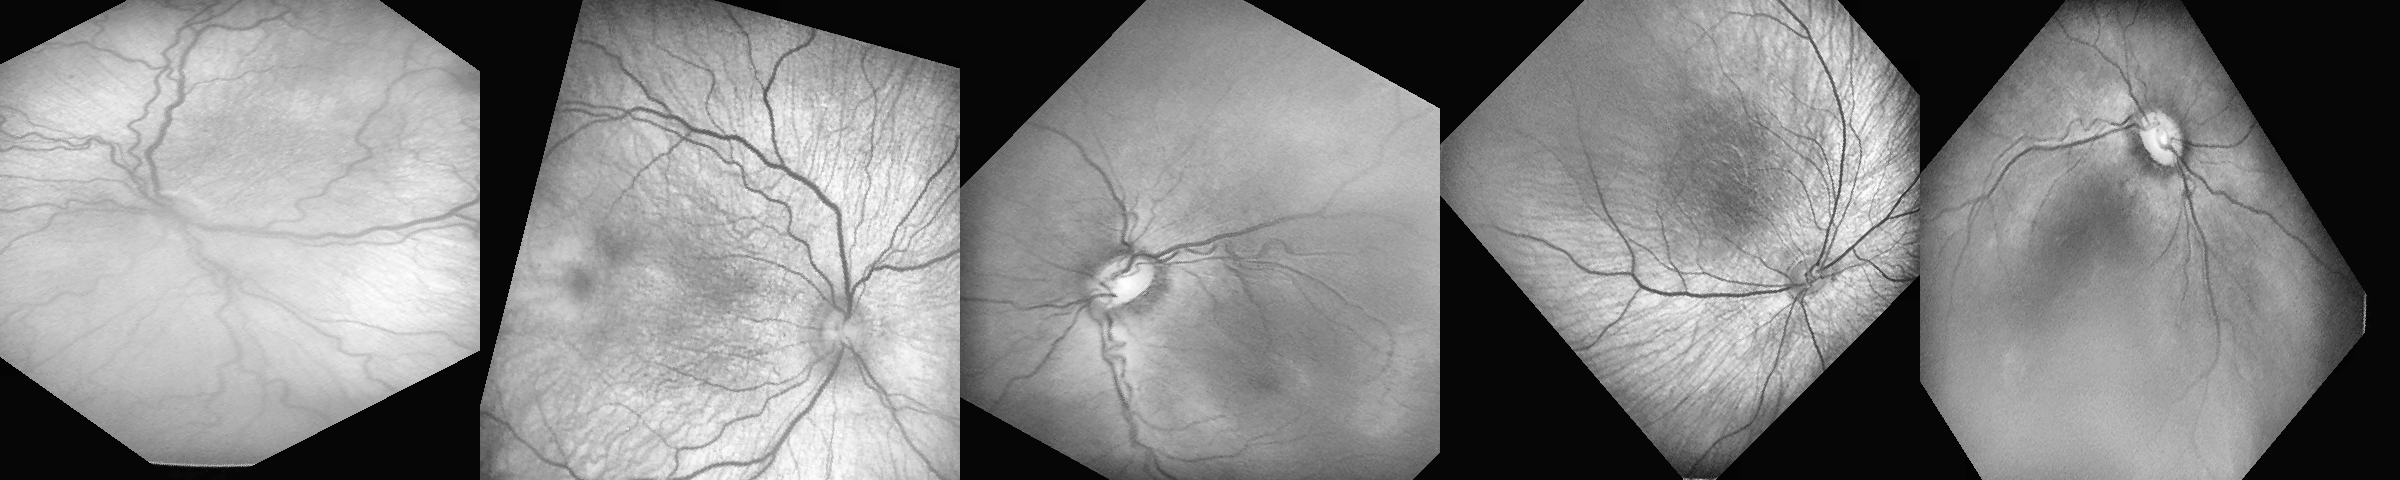

In [10]:
visualize(group_images(raw_train_processed[100:105,:,:,:],5),'raw_img')

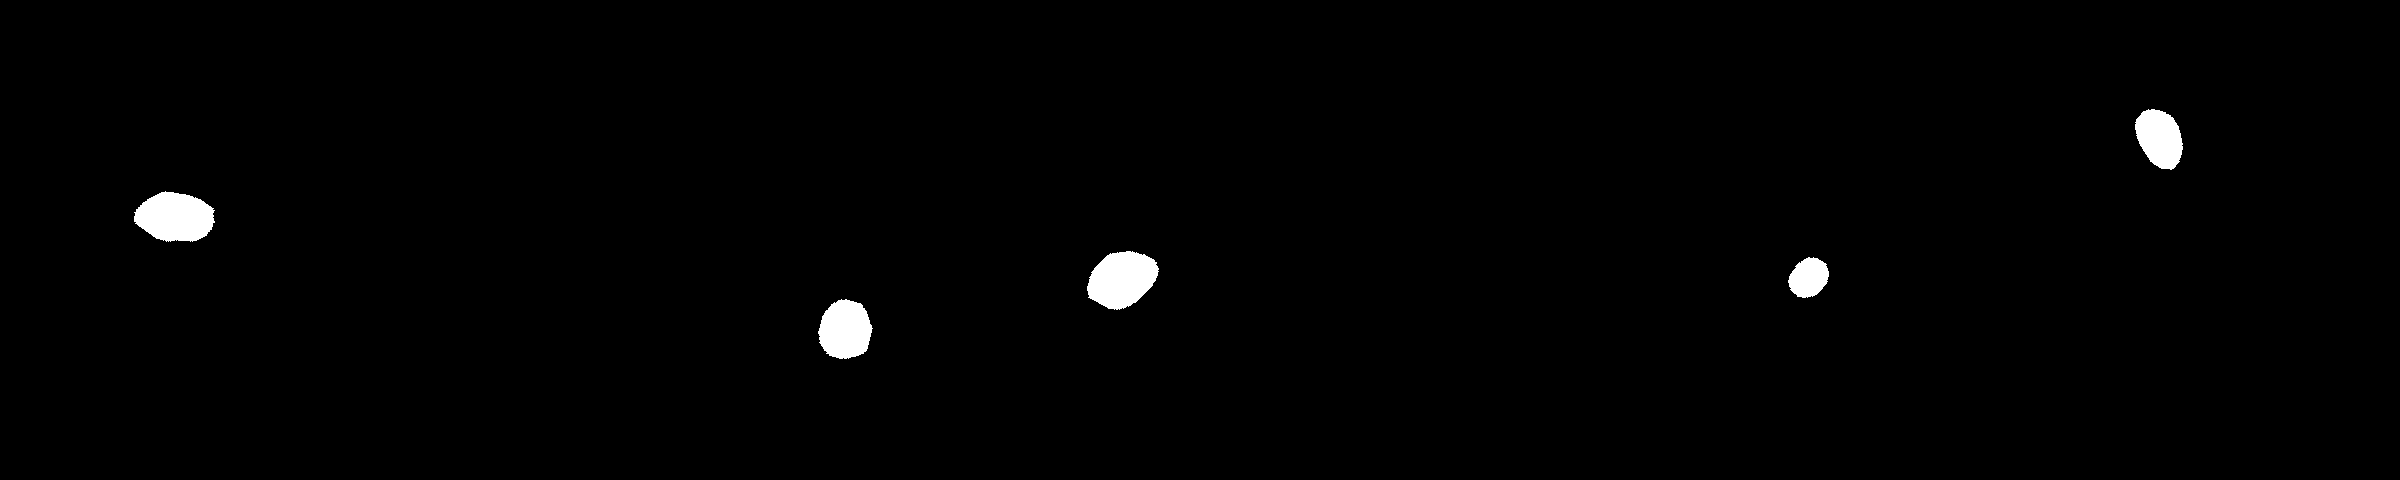

In [11]:
visualize(group_images(mask_train[100:105,:,:,:],5),'raw_img')

# Extract Patches

In [12]:
patches_imgs_train, patches_masks_train = extract_random(raw_train_processed,
                                                                   mask_train,
                                                                   patch_height,
                                                                   patch_width,
                                                                   N_subimgs,
                                                                   inside_FOV)

patches per full image: 1000


In [13]:
mask_train.shape

(438, 1, 480, 480)

In [14]:
patches_masks_train.shape

(438000, 1, 48, 48)

# Training


In [15]:
def get_unet2(n_ch,patch_height,patch_width):
    inputs = Input(shape=(n_ch,patch_height,patch_width))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(inputs)
    conv1 = BatchNormalization(axis=1)(conv1)
    conv1 = Dropout(0.3)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv1)
    conv1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D((2, 2), data_format='channels_first')(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool1)
    conv2 = BatchNormalization(axis=1)(conv2)
    conv2 = Dropout(0.3)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv2)
    conv2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D((2, 2), data_format='channels_first')(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool2)
    conv3 = BatchNormalization(axis=1)(conv3)
    conv3 = Dropout(0.3)(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv3)
    conv3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D((2, 2), data_format='channels_first')(conv3)
    
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool3)
    conv4 = BatchNormalization(axis=1)(conv4)
    conv4 = Dropout(0.3)(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv4)
    conv4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D((2, 2), data_format='channels_first')(conv4)

    
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool4)
    conv5 = BatchNormalization(axis=1)(conv5)
    conv5 = Dropout(0.3)(conv5)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv5)
    conv5 = BatchNormalization(axis=1)(conv5)
    
    up1 = UpSampling2D(size=(2, 2), data_format='channels_first')(conv5)
    up1 = concatenate([conv4,up1],axis=1)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(up1)
    conv6 = BatchNormalization(axis=1)(conv6)
    conv6 = Dropout(0.3)(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv6)
    conv6 = BatchNormalization(axis=1)(conv6)

    up2 = UpSampling2D(size=(2, 2), data_format='channels_first')(conv6)
    up2 = concatenate([conv3,up2],axis=1)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(up2)
    conv7 = BatchNormalization(axis=1)(conv7)
    conv7 = Dropout(0.3)(conv7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv7)
    conv7 = BatchNormalization(axis=1)(conv7)

    up3 = UpSampling2D(size=(2, 2), data_format='channels_first')(conv7)
    up3 = concatenate([conv2,up3],axis=1)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(up3)
    conv8 = BatchNormalization(axis=1)(conv8)
    conv8 = Dropout(0.3)(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv8)
    conv8 = BatchNormalization(axis=1)(conv8)

    up4 = UpSampling2D(size=(2, 2), data_format='channels_first')(conv8)
    up4 = concatenate([conv1,up4],axis=1)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(up4)
    conv9 = BatchNormalization(axis=1)(conv9)
    conv9 = Dropout(0.3)(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv9)
    conv9 = BatchNormalization(axis=1)(conv9)

    
    conv10 = Conv2D(2, (1, 1), activation='relu', padding='same',data_format='channels_first')(conv9)
    conv10 = BatchNormalization(axis=1)(conv10)
    conv10 = core.Reshape((2,patch_height*patch_width))(conv10)
    conv10 = core.Permute((2,1))(conv10)
    ############
    conv10 = core.Activation('softmax')(conv10)

    model = Model(input=inputs, output=conv10)

    adaGrad = Adagrad(lr=1e-7, epsilon=1e-7, decay=1e-6)
    model.compile(optimizer='sgd', loss='categorical_crossentropy',metrics=['accuracy'])

    return model

In [16]:
n_ch = patches_imgs_train.shape[1]
patch_height = patches_imgs_train.shape[2]
patch_width = patches_imgs_train.shape[3]
#model = get_unet2(n_ch, patch_height, patch_width)  #the U-net model
learningrate = 0.01
model = get_unet2(n_ch, patch_height,patch_width)
# Optimizers
adaGrad = Adagrad(lr=learningrate, epsilon=1e-7, decay=1e-6)
sgd = SGD(lr=learningrate, decay=1e-6, momentum=0.9, nesterov=False)
adam = Adam(lr=learningrate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#model.compile(optimizer=sgd, loss='categorical_crossentropy',metrics=['accuracy', mean_IOU_gpu])
model.compile(optimizer=sgd, loss= log_dice_loss,metrics=['accuracy', mean_IOU_gpu])

model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 48, 48)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 48, 48)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 48, 48)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32, 48, 48)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

/home/sh402/retina-unet/rop_env_cpu/lib/python2.7/site-packages/ipykernel_launcher.py:78: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ac..., inputs=Tensor("in...)`


![](u-net-architecture.png)

In [ ]:
# Training the model, which should be execute on GPU environment
model.fit(patches_imgs_train, patches_masks_train, nb_epoch=N_epochs, batch_size=batch_size, verbose=2, shuffle=True, validation_split=0.1)

# Test data

In [25]:
# Test data parameters setting
path_experiment = "DISC_segmentation/"
name_experiment = "DISC_segmentation_trim_augmentation_extract_4848_1to3_sgd_unet2_diceloss"

input_path = path_experiment+ name_experiment + '/' +  name_experiment 
output_path = path_experiment+  name_experiment 

best_last = "best"
Imgs_to_test = 15
patch_height = 48
patch_width = 48
average_mode = False
is_extract = True
overlap = False
stride_h = 2
stride_w = 2
trim = True

full_img_height = 480
full_img_width = 480

In [20]:

test_imgs_original = load_hdf5("DISC/raw_test.hdf5")
test_masks = load_hdf5("DISC/mask_test.hdf5")

test_imgs = my_PreProc(test_imgs_original)
#test_masks = test_masks/255.

#extend both images and masks so they can be divided exactly by the patches dimensions
test_imgs = test_imgs[0:Imgs_to_test,:,:,:]
test_masks = test_masks[0:Imgs_to_test,:,:,:]

if trim == True:
    test_imgs = test_imgs[:,:,:,80:560]
    test_masks = test_masks[:,:,:,80:560]

if is_extract == True:
    test_imgs = paint_border(test_imgs,patch_height,patch_width)
    test_masks = paint_border(test_masks,patch_height,patch_width)
    
    if overlap == True:
        patches_imgs_test = extract_ordered_overlap(test_imgs, patch_height, patch_width,stride_h,stride_w)
        #patches_masks_test = extract_ordered_overlap(test_masks, patch_height, patch_width,stride_h,stride_w)
    else:
        patches_imgs_test = extract_ordered(test_imgs,patch_height,patch_width)
        patches_masks_test = extract_ordered(test_masks,patch_height,patch_width)
else:
    patches_imgs_test = test_imgs
    patches_masks_test = test_masks
    

number of patches per image: 100
number of patches per image: 100


In [21]:
#model = model_from_json(open(path_experiment+name_experiment +'_architecture.json').read())
model = model_from_json(open("DISC_segmentation/DISC_segmentation_trim_augmentation_extract_4848_1to3_sgd_unet2_diceloss/DISC_segmentation_trim_augmentation_extract_4848_1to3_sgd_unet2_diceloss_architecture.json").read())
#model = model_from_json(open(path_experiment  + 'DISC_segmentation_' + name_experiment + '/' + 'DISC_segmentation_' + name_experiment + '_architecture.json').read())
model.load_weights("DISC_segmentation/DISC_segmentation_trim_augmentation_extract_4848_1to3_sgd_unet2_diceloss/DISC_segmentation_trim_augmentation_extract_4848_1to3_sgd_unet2_diceloss_best_weights.h5")
#Calculate the predictions
predictions = model.predict(patches_imgs_test, batch_size=32, verbose=2)
print "predicted images size :"
print predictions.shape


#===== Convert the prediction arrays in corresponding images
pred_patches = pred_to_imgs(predictions, patch_height, patch_width, "original")


predicted images size :
(1500, 2304, 2)


In [28]:
pred_imgs = None
orig_imgs = None
gtruth_masks = None


if average_mode == True:
    pred_imgs = recompone_overlap(pred_patches, full_img_height, full_img_width, stride_h, stride_w)# predictions
    orig_imgs = my_PreProc(test_imgs_original[0:pred_imgs.shape[0],:,:,:])    #originals
    gtruth_masks = test_masks  #ground truth masks
else:
    pred_imgs = recompone(pred_patches,10,10)       # predictions
    orig_imgs = recompone(patches_imgs_test,10,10)  # originals
    gtruth_masks = recompone(patches_masks_test,10,10)  #masks
    
# apply the DRIVE masks on the repdictions #set everything outside the FOV to zero!!
#kill_border(pred_imgs, test_border_masks)  #DRIVE MASK  #only for visualization
## back to original dimensions
orig_imgs = orig_imgs[:,:,0:full_img_height,0:full_img_width]
pred_imgs = pred_imgs[:,:,0:full_img_height,0:full_img_width]
gtruth_masks = gtruth_masks[:,:,0:full_img_height,0:full_img_width]
print "Orig imgs shape: " +str(orig_imgs.shape)
print "pred imgs shape: " +str(pred_imgs.shape)
print "Gtruth imgs shape: " +str(gtruth_masks.shape)


N_visual = 5
visualize(group_images(orig_imgs,N_visual),output_path + "all_originals")#.show()
visualize(group_images(pred_imgs,N_visual),output_path + "all_predictions")#.show()
visualize(group_images(gtruth_masks,N_visual),output_path+ "all_groundTruths")#.show()
#visualize results comparing mask and prediction:
assert (orig_imgs.shape[0]==pred_imgs.shape[0] and orig_imgs.shape[0]==gtruth_masks.shape[0])
N_predicted = orig_imgs.shape[0]
group = N_visual
assert (N_predicted%group==0)
for i in range(int(N_predicted/group)):
    orig_stripe = group_images(orig_imgs[i*group:(i*group)+group,:,:,:],group)
    masks_stripe = group_images(gtruth_masks[i*group:(i*group)+group,:,:,:],group)
    pred_stripe = group_images(pred_imgs[i*group:(i*group)+group,:,:,:],group)
    #total_img = np.concatenate((orig_stripe,masks_stripe,pred_stripe),axis=0)
    total_img = np.concatenate((orig_stripe,pred_stripe),axis=0)
    visualize(total_img,output_path + "_Original_GroundTruth_Prediction"+str(i))#.show()
    


Orig imgs shape: (15, 1, 480, 480)
pred imgs shape: (15, 1, 480, 480)
Gtruth imgs shape: (15, 1, 480, 480)


In [29]:
for threshold in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]:
    t = np.where(pred_imgs > threshold, 1, 0)
    
    iou = []
    dice = []

    for i in range(len(pred_imgs)):
        intersect = 0
        union = 0
        true = np.asarray(gtruth_masks[i].reshape(-1))
        scores = np.asarray(t[i].reshape(-1))
        for j in range(len(true)):
            if true[j] == 1 and scores[j] == 1:
                intersect += 1
            if true[j] == 1 or scores[j] == 1:
                union += 1
        
    
    
        iou.append(intersect/float(union))
        dice.append(intersect*2/float(np.sum(true == 1) + np.sum(scores == 1)))

    print("threshold = ", threshold)
    print("mean iou = ", np.mean(iou))
    print("mean dice = ", np.mean(dice))

('threshold = ', 0.1)
('mean iou = ', 0.6772083307179304)
('mean dice = ', 0.8000721555069149)
('threshold = ', 0.2)
('mean iou = ', 0.7232215598978251)
('mean dice = ', 0.8315820816520028)
('threshold = ', 0.3)
('mean iou = ', 0.7371348386109263)
('mean dice = ', 0.8390786242895065)
('threshold = ', 0.4)
('mean iou = ', 0.7436793183464007)
('mean dice = ', 0.840986746909221)
('threshold = ', 0.5)
('mean iou = ', 0.7449503096713331)
('mean dice = ', 0.8386930843434602)
('threshold = ', 0.6)
('mean iou = ', 0.7406221881808696)
('mean dice = ', 0.8326697153743704)
('threshold = ', 0.7)
('mean iou = ', 0.7330753113534777)
('mean dice = ', 0.82543845611439)
('threshold = ', 0.8)
('mean iou = ', 0.7224860949785352)
('mean dice = ', 0.8171737340886653)


# Example Test Results
### The results were shown in Raw Image - Ground Truth Mask - Prediction Mask

In [31]:
from IPython.display import Image

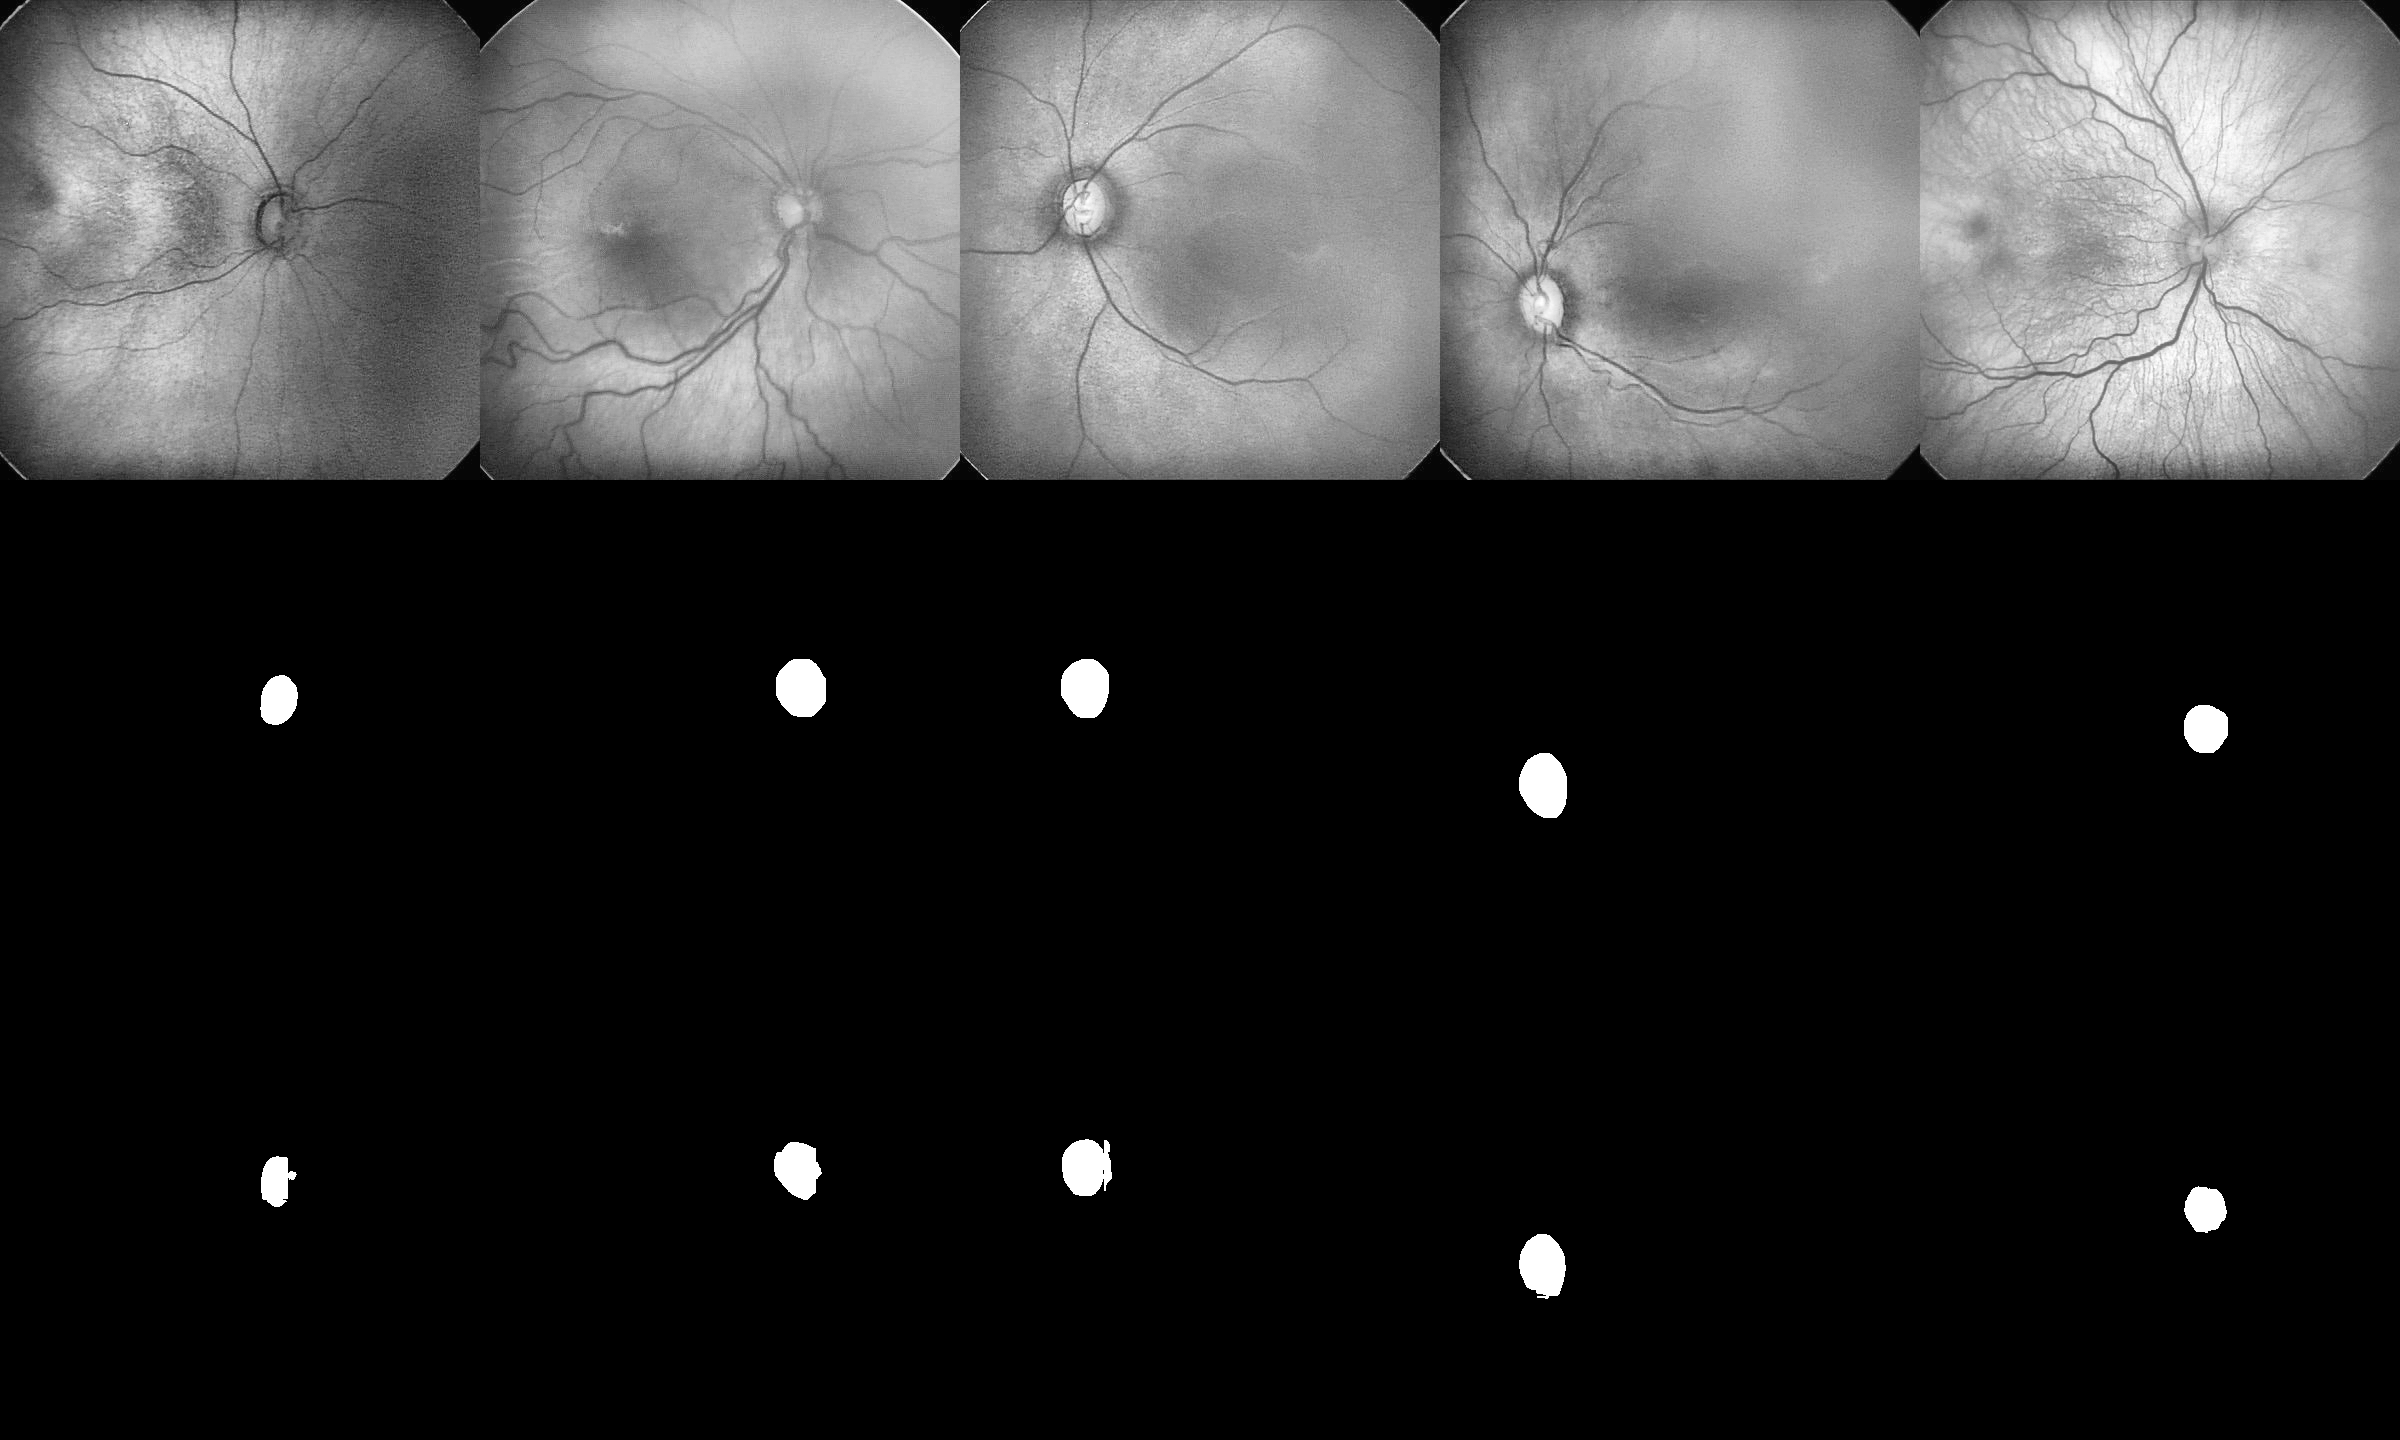

In [30]:
Image("DISC_segmentation/DISC_segmentation_trim_augmentation_extract_4848_1to3_sgd_unet2_diceloss/_Original_GroundTruth_Prediction0.png")

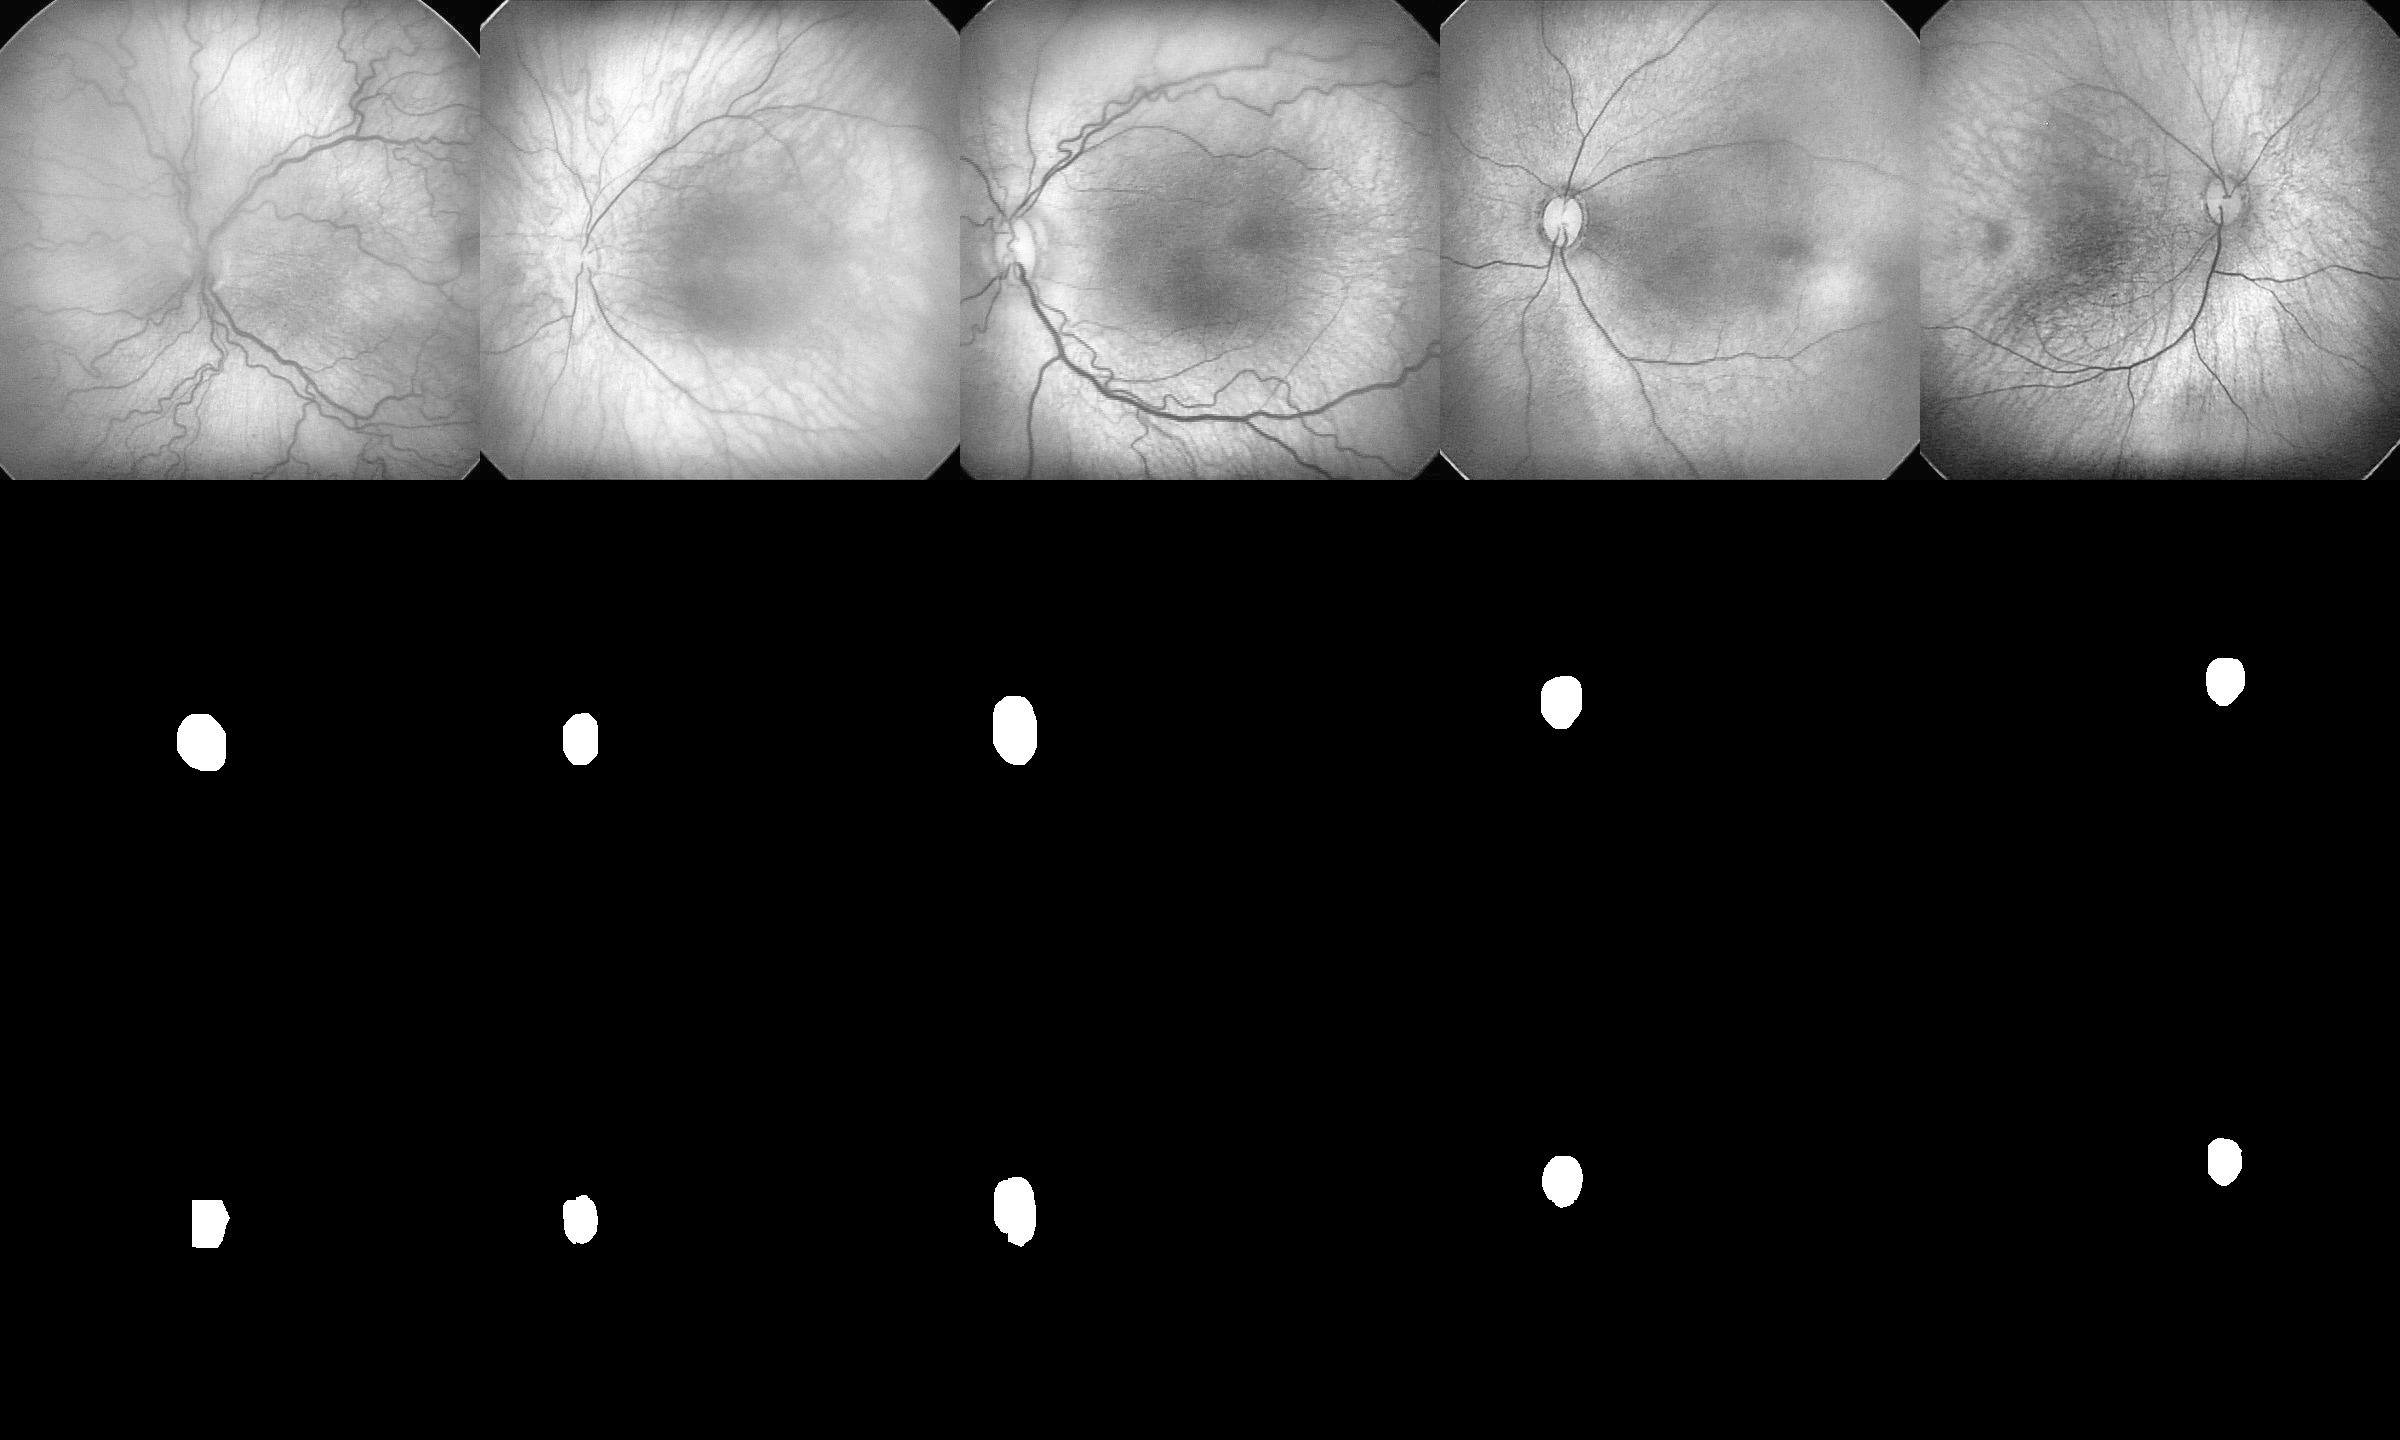

In [32]:
Image("DISC_segmentation/DISC_segmentation_trim_augmentation_extract_4848_1to3_sgd_unet2_diceloss/_Original_GroundTruth_Prediction1.png")

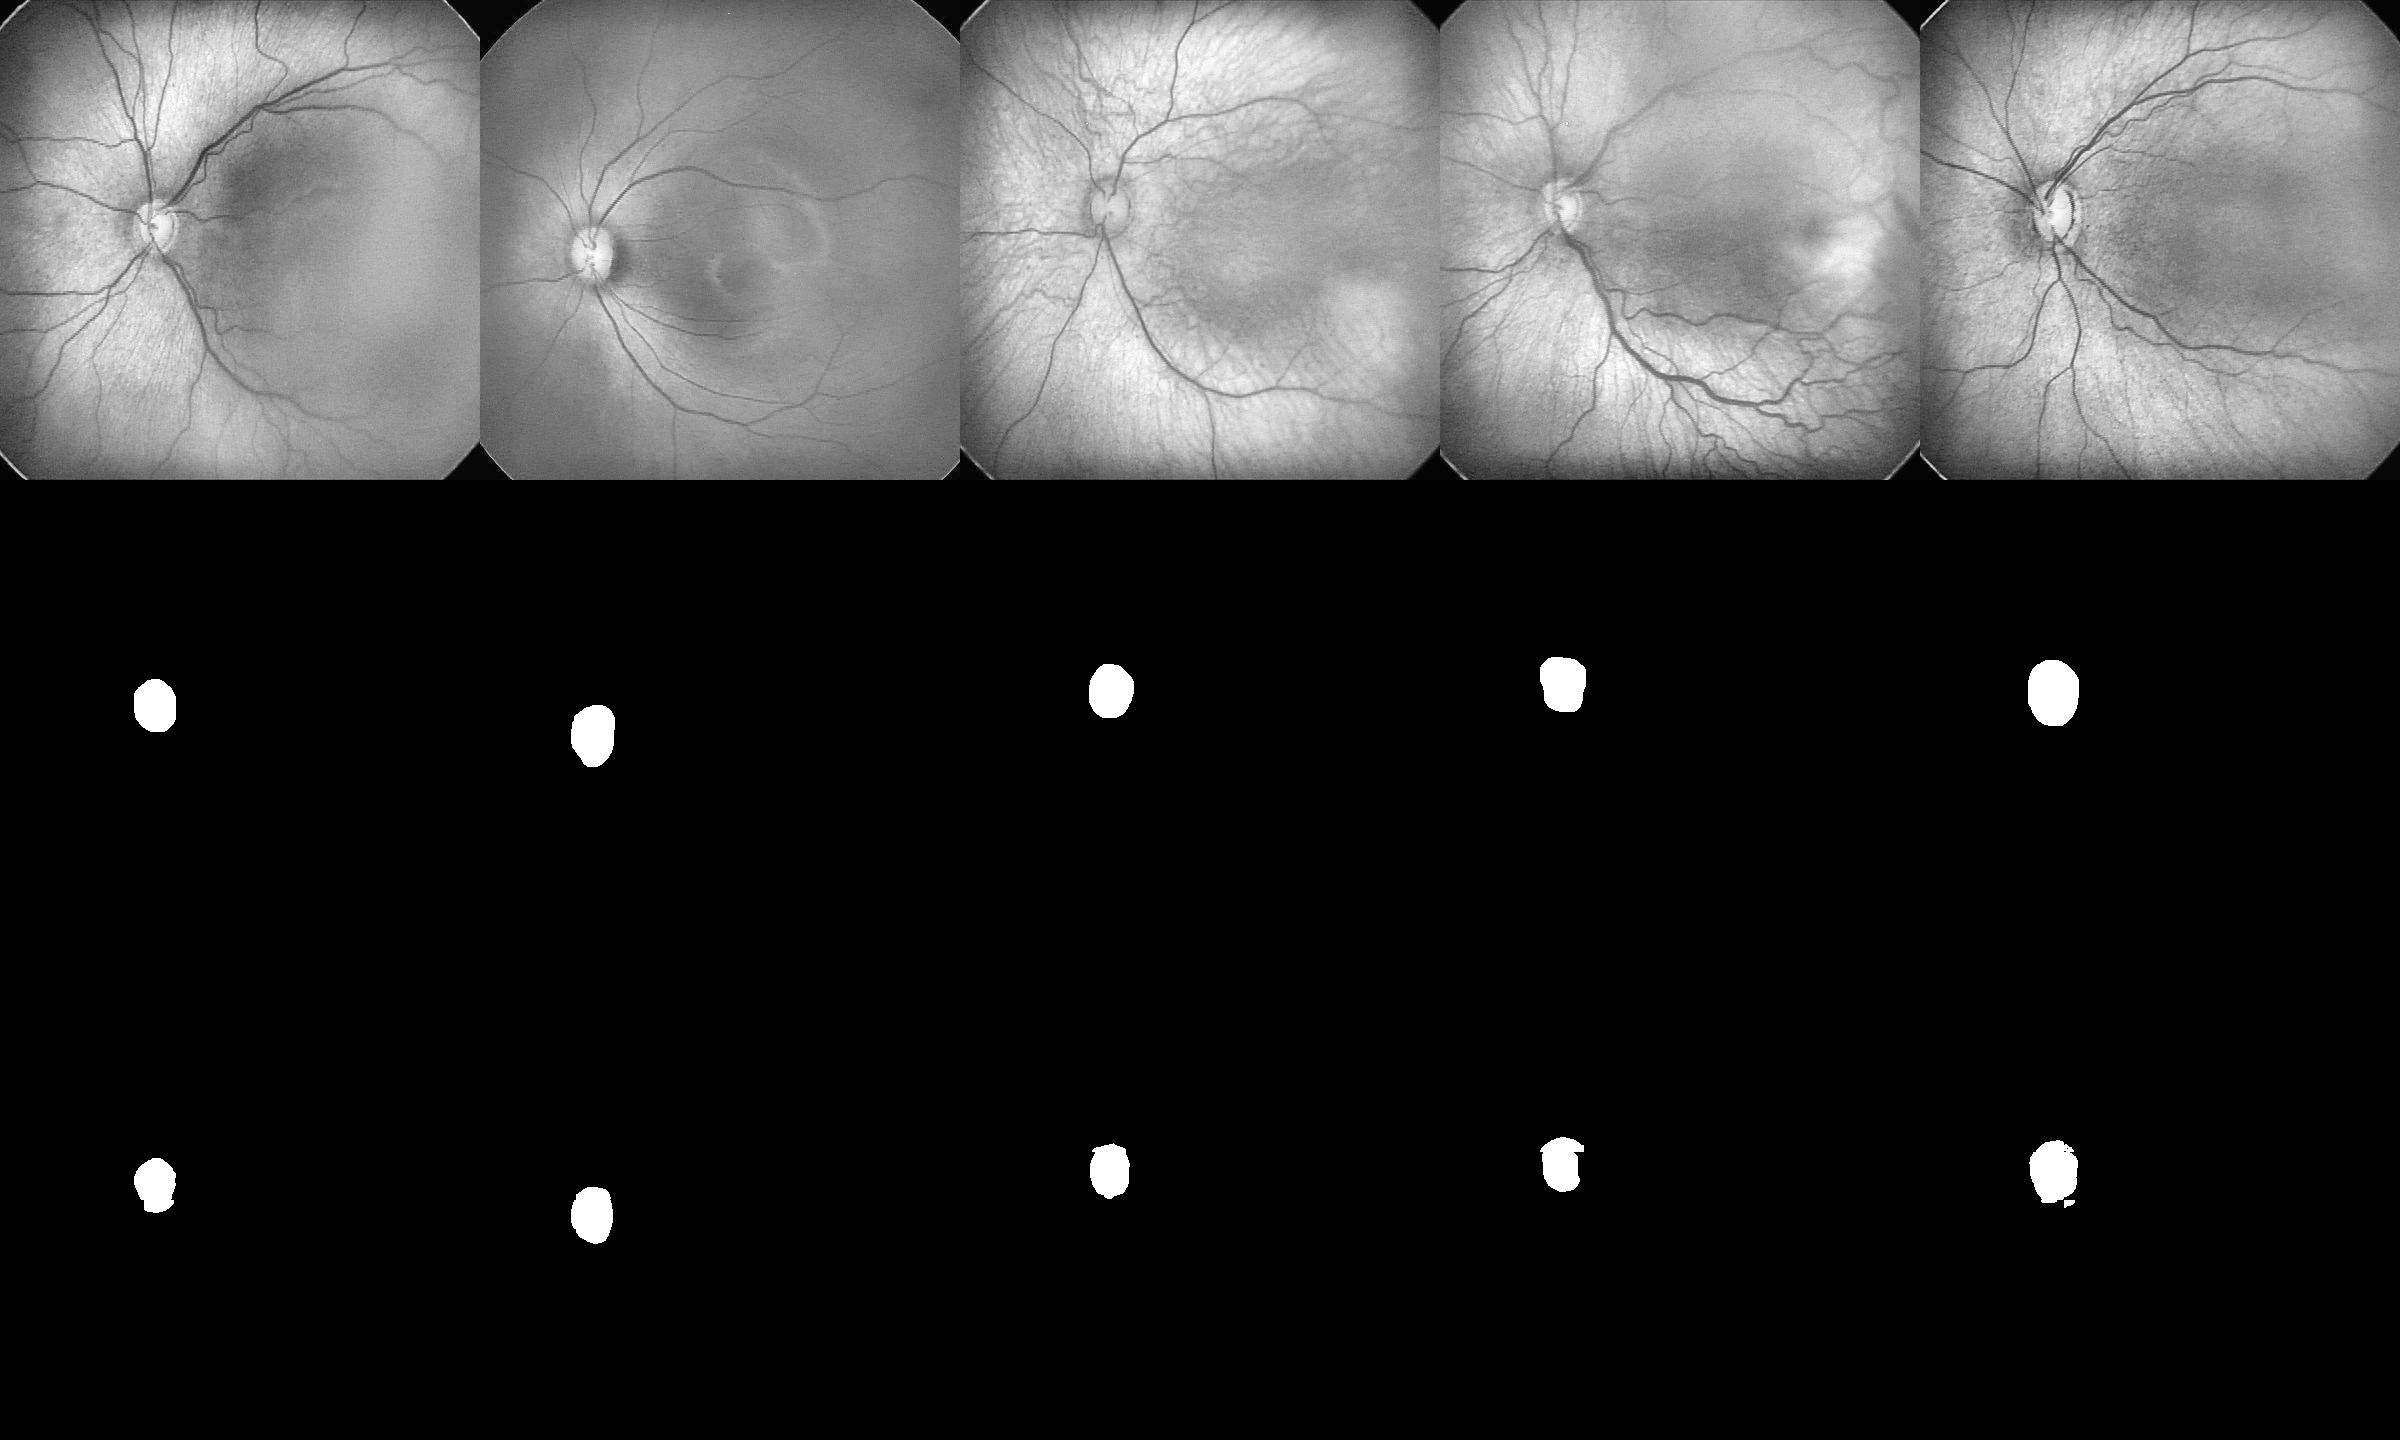

In [33]:
Image("DISC_segmentation/DISC_segmentation_trim_augmentation_extract_4848_1to3_sgd_unet2_diceloss/_Original_GroundTruth_Prediction2.png")

# Test on Open Source Dataset: DRIVE 

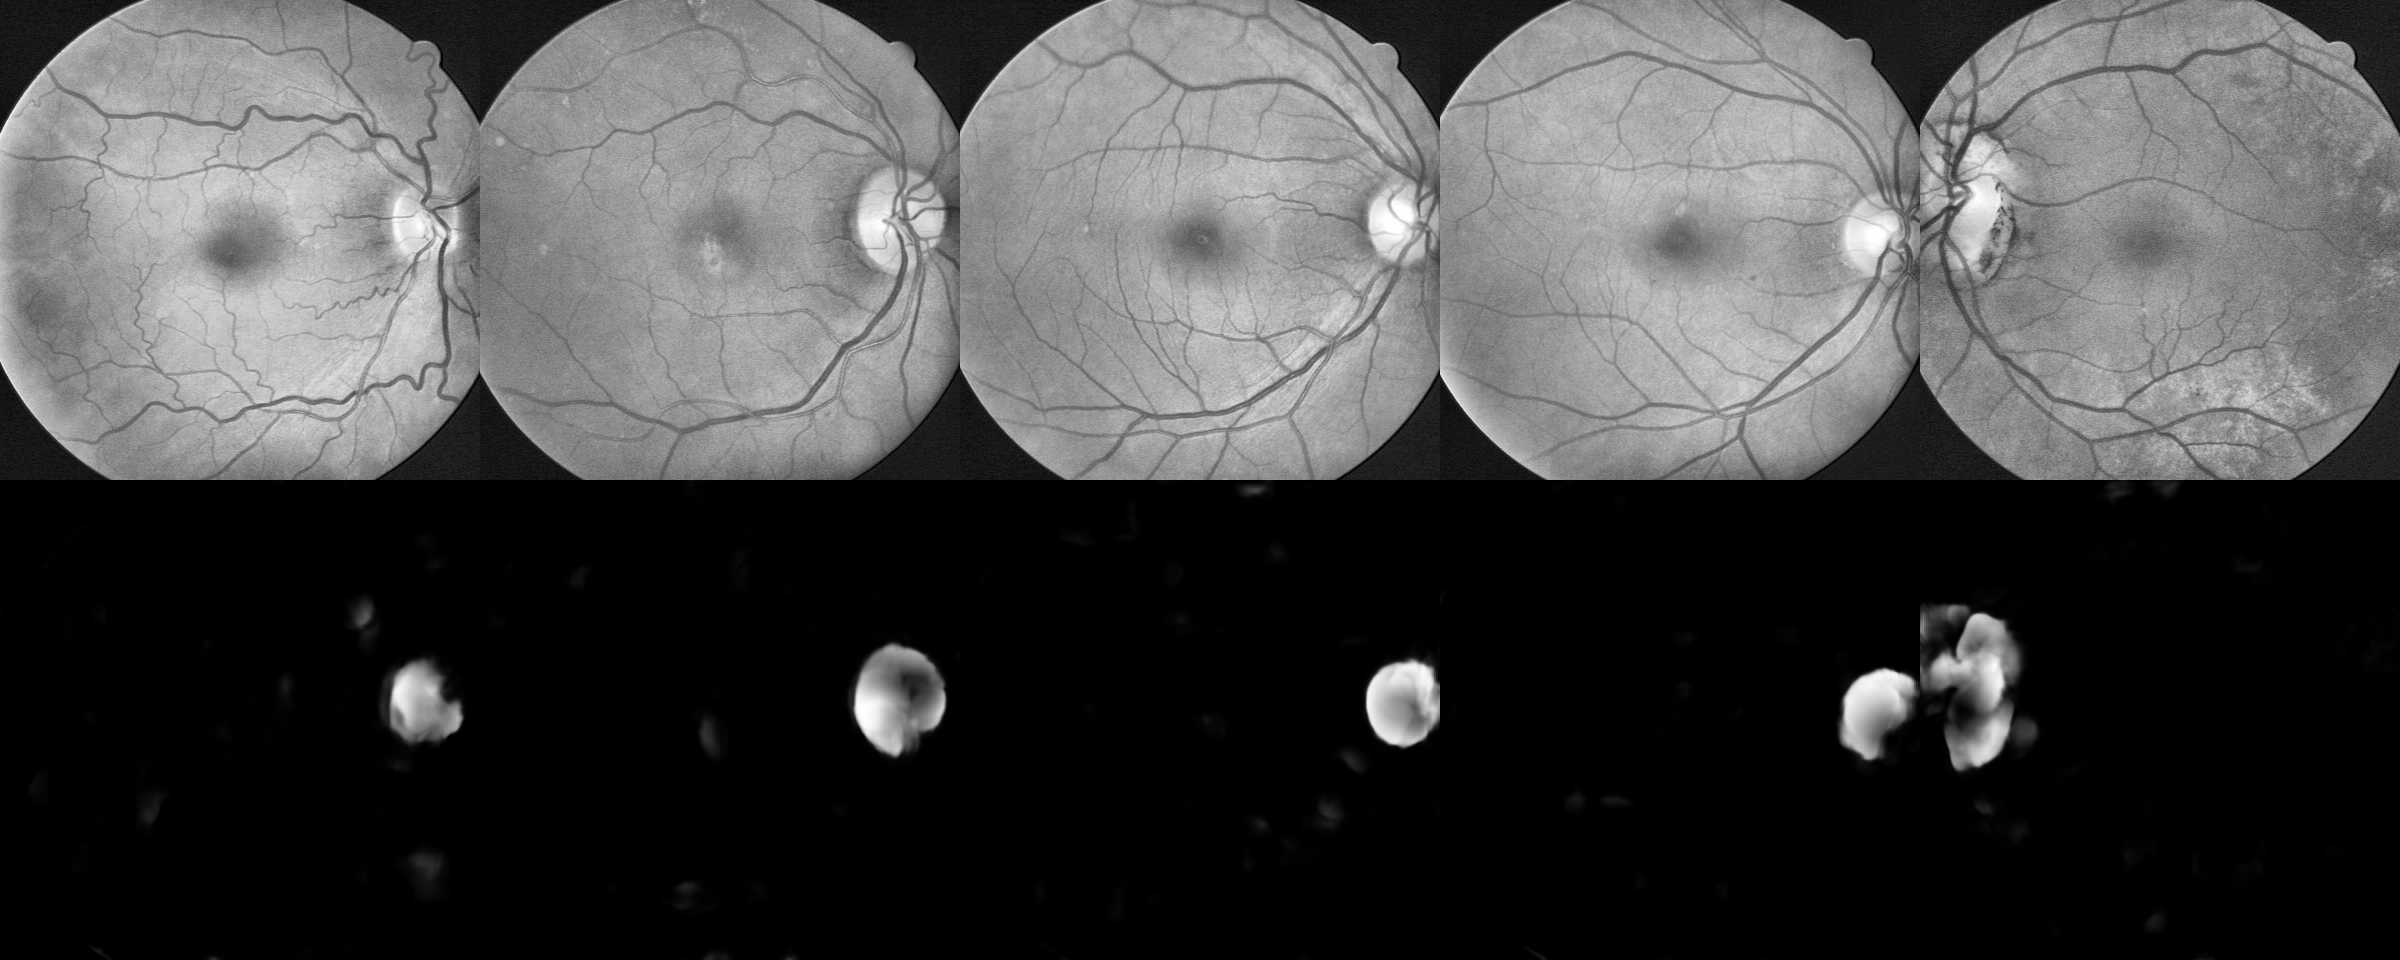

In [34]:
Image("DISC_segmentation/DISC_segmentation_trim_augmentation_extract_4848_1to3_sgd_unet2_diceloss/DRIVE__Original_GroundTruth_Prediction0.png")

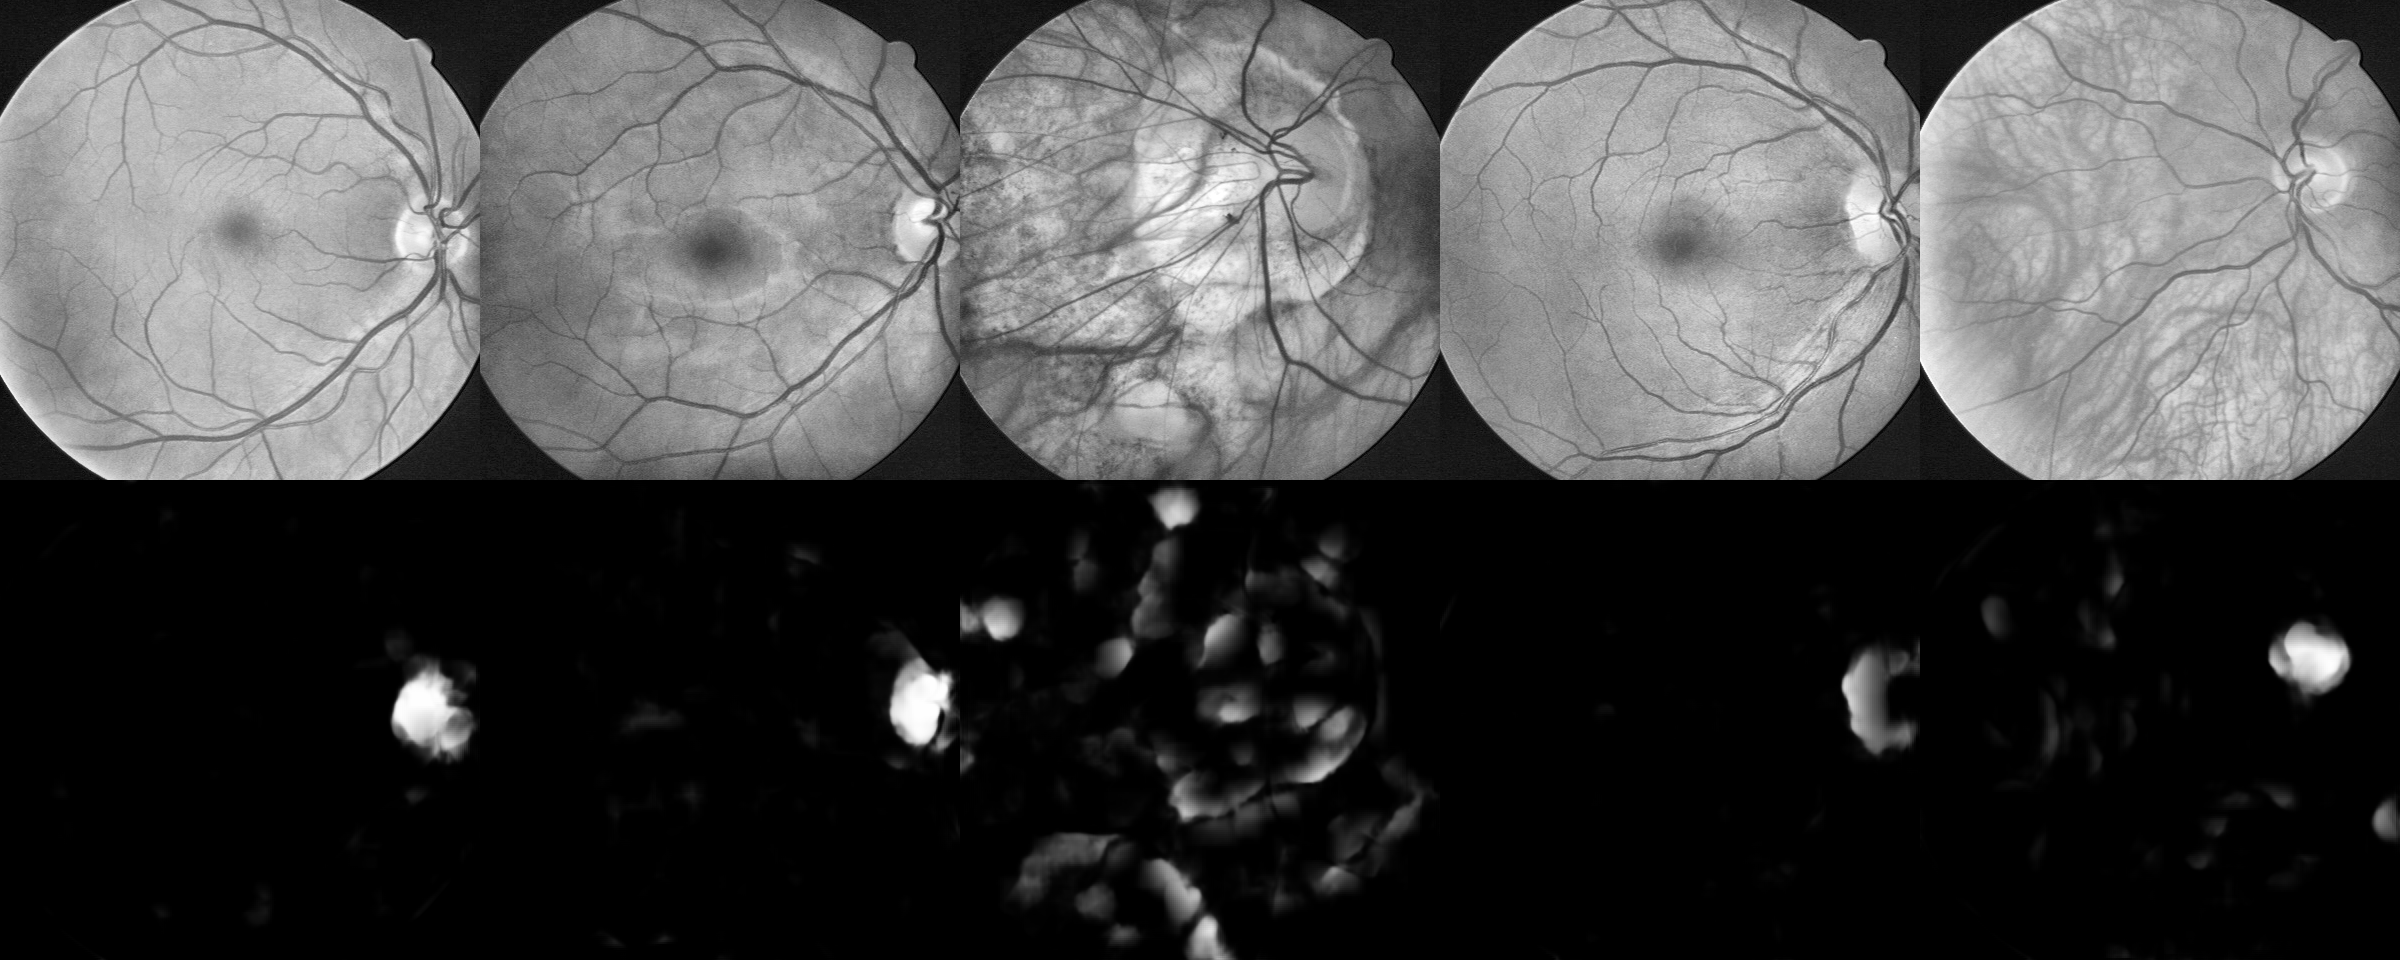

In [35]:
Image("DISC_segmentation/DISC_segmentation_trim_augmentation_extract_4848_1to3_sgd_unet2_diceloss/DRIVE__Original_GroundTruth_Prediction1.png")